# Creating NLP Word Embeddings with PyTorch

In [1]:
# https://stackoverflow.com/questions/50747947/embedding-in-pytorch
# https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from IPython.display import clear_output
import time

In [3]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
#!pip install wikipedia
import wikipedia

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import mpld3
mpld3.enable_notebook()
#!pip install --user "git+https://github.com/javadba/mpld3@display_fix"

## Load and Preprocess Corpus

# Training the Embeddings with Language Model

## Continuous Bag-of-Words (CBOW)

context vs target

In [22]:
print(c)

tensor([   1,   40,  315,  715,    4, 1912,   23,    5,  193,    3,   38, 1037,
        1913, 1914,   44,  164,   15,    4,   40,  716,  177, 1382,  337,    9,
         194, 1383,   35,  860,   44,  246,    9,   38,   69,  104,  178,    3,
          40,  268,  177,   40, 1915,   10,  620,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])


In [24]:
context_size = 2
end_position = (c==2).nonzero().item()

samples_to_print = np.concatenate((np.arange(1,5),np.arange(end_position-5,end_position)),axis=0)
for pos in samples_to_print: # range(1,end_position):
    
    middle_word   = c[pos]
    
    '''if middle_word==wiki_crawler.word2idx['<END>']:
        break'''
    
    left_start = max(pos-context_size,1)
    right_end  = min(pos+1+context_size,end_position)
    
    
    if pos - left_start < context_size:                # first words position
        right_end += context_size-(pos-left_start)     # --> increse right_context size
    elif right_end-(pos+1) < context_size:             # last words position
        left_start -= context_size-(right_end-(pos+1)) # --> increase left_context size
            
    left_context  = c[left_start:pos]
    right_context = c[pos+1:right_end]
    
    context       = torch.cat((left_context,right_context),dim=0)
    
    print(f' Left context: {left_context.tolist()}, Middle word: {middle_word.tolist()}, right context {right_context.tolist()}')
    print(f' Full context: {context.tolist()}')
    
    context_decoded     = wiki_crawler.decode_one_sentence(context.tolist())
    middle_word_decoded = wiki_crawler.decode_one_sentence([middle_word.tolist()])
    print(f' Words in context of {middle_word_decoded}: {context_decoded}')
    print('')

 Left context: [], Middle word: 40, right context [315, 715, 4, 1912]
 Full context: [315, 715, 4, 1912]
 Words in context of ['rainha']: ['antigo', 'ray', 'a', 'reynna']

 Left context: [40], Middle word: 315, right context [715, 4, 1912]
 Full context: [40, 715, 4, 1912]
 Words in context of ['antigo']: ['rainha', 'ray', 'a', 'reynna']

 Left context: [40, 315], Middle word: 715, right context [4, 1912]
 Full context: [40, 315, 4, 1912]
 Words in context of ['ray']: ['rainha', 'antigo', 'a', 'reynna']

 Left context: [315, 715], Middle word: 4, right context [1912, 23]
 Full context: [315, 715, 1912, 23]
 Words in context of ['a']: ['antigo', 'ray', 'reynna', 'é']

 Left context: [40, 268], Middle word: 177, right context [40, 1915]
 Full context: [40, 268, 40, 1915]
 Words in context of ['exemplo']: ['rainha', 'consorte', 'rainha', 'silvia']

 Left context: [268, 177], Middle word: 40, right context [1915, 10]
 Full context: [268, 177, 1915, 10]
 Words in context of ['rainha']: ['co

In [25]:
def get_context(coded_sentence, context_size):
    
    end_position = (c==2).nonzero().item()
    target_context = []
    for pos in range(1,end_position):
        middle_word   = coded_sentence[pos]

        left_start = max(pos-context_size,1)
        right_end  = min(pos+1+context_size,end_position)

        if pos - left_start < context_size:                # first words position
            right_end += context_size-(pos-left_start)     # --> increse right_context size
        elif right_end-(pos+1) < context_size:             # last words position
            left_start -= context_size-(right_end-(pos+1)) # --> increase left_context size

        left_context  = c[left_start:pos]
        right_context = c[pos+1:right_end]
        
        context       = torch.cat((left_context,right_context),dim=0)
        
        target_context.append((middle_word.view((-1)),context))
    return target_context

In [26]:
def average_context_ohe(context):
    
    avg_context = np.zeros((V,len(context)))
    avg_context[context, range(len(context))] = 1
    avg_context = np.mean(avg_context,axis=1,keepdims=True)
    #np.where(avg_context), context
    
    return torch.FloatTensor(avg_context.T)

In [27]:
class Language_Model_w2v(nn.Module):
    
    def __init__(self, vocab_size, num_of_dimensions_of_embedding, context_size):
        super(Language_Model_w2v, self).__init__()
        self.V  = vocab_size
        self.N  = num_of_dimensions_of_embedding 
        self.cs = context_size
        
        self.W1  =  nn.Linear(self.V, self.N)
        '''
        self.W1 = nn.Linear(2*self.cs*self.N,128)
        self.W2 = nn.Linear(128, self.V)
        '''
        # self.layers = nn.Sequential(*[self.e, self.W1, self.W2,self.LogSoftMax])
        
        self.Winv = nn.Linear(self.N, self.V)
        self.LogSoftMax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):               # x is 2*cs x 1
        x = self.W1(x)
        x = self.Winv(x)
        x = self.LogSoftMax(x)
        
        return x
        ''' 
        x = self.e(x).view((1,-1))     # e(x) 2*cs x N
        x = self.W1(x)
        x = F.relu(x)
        x = self.W2(x)
        log_probs = self.LogSoftMax(x)
        return log_probs
        '''

In [28]:
max_epochs = 5
print_iters = 50
cs = 3
Nd = 50
losses    = []
criterion = nn.NLLLoss()
model     = Language_Model_w2v(V, num_of_dimensions_of_embedding=Nd, context_size=cs)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # optim.SGD(model.parameters(),lr=1e-3) # 

In [29]:
model

Language_Model_w2v(
  (W1): Linear(in_features=2003, out_features=50, bias=True)
  (Winv): Linear(in_features=50, out_features=2003, bias=True)
  (LogSoftMax): LogSoftmax()
)

In [30]:
for epoch in range(max_epochs):
    
    cnt = 0
    total_loss = 0
    
    coded_sentences = coded_sentences[:,np.random.permutation(S)]
    
    for n in range(S):
        
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words into integer indices and wrap them in tensors)
        c = coded_sentences[:,n]
        
        pos_cnt = 0
        for target, context in get_context(c, cs):
            pos_cnt += 1
            if len(context)<2*cs:
                continue
            
            # Step 2. Recall that torch *accumulates* gradients. 
            # Before passing in a new instance, you need to zero out the gradients from the oldinstance
            model.zero_grad()
            
            # Step 3. Run the forward pass, getting log probabilities over next words
            log_probs = model(average_context_ohe(context))  
            
            # Step 4. Compute your loss function. 
            # (Again, Torch wants the target word wrapped in a tensor)
            loss = criterion(log_probs, target)

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()
            
        cnt+=1
        if n%print_iters==1:
            print(f'epoch {epoch} sentence {n}/{S} loss: {total_loss:.5f}')
    print(f'loss: {total_loss:.6f}')
    losses.append(total_loss)
    
    time.sleep(1.5)
    clear_output()
#print(losses)  # The loss decreased every iteration over the training data!

In [31]:
pos_cnt

24

In [32]:
losses

[214547.6391415596,
 205302.89374177344,
 196471.93149525323,
 183790.8839714229,
 173963.17807273776]

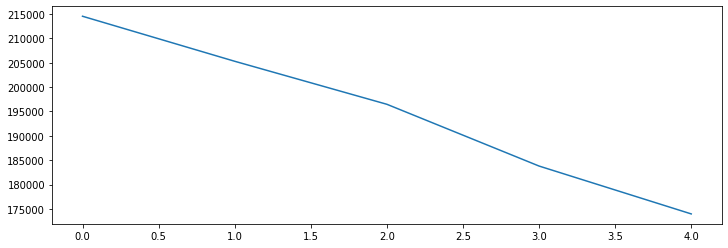

In [33]:
plt.figure(figsize=(12,4))

plt.plot(losses)
plt.show()

In [34]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape) # param.data

W1.weight torch.Size([50, 2003])
W1.bias torch.Size([50])
Winv.weight torch.Size([2003, 50])
Winv.bias torch.Size([2003])


In [35]:
Embedding = model.W1.weight.data.T
Embedding.shape, Embedding

(torch.Size([2003, 50]),
 tensor([[-0.0945, -0.0795,  0.1063,  ...,  0.2807,  0.2459,  0.4310],
         [ 0.9508,  0.8786, -0.4062,  ...,  0.0645,  0.0141, -0.9514],
         [ 1.0052,  0.6529,  0.4714,  ..., -0.4338,  0.1653, -0.9840],
         ...,
         [-0.0330, -0.1582, -0.1398,  ..., -0.0497,  0.3821,  0.0040],
         [-0.0673, -0.0117,  0.1728,  ...,  0.1069,  0.1696, -0.1179],
         [-0.0441, -0.0479,  0.3877,  ...,  0.1611,  0.2028,  0.1006]]))

In [36]:
def word_analogy(pos_neg_1=('king','man'),pos_neg_2=('queen','woman'), n_closest = 4):
    king_w,    man_w = pos_neg_1
    queen_w, woman_w = pos_neg_2
    
    for w in (king_w,man_w,woman_w):
        if w not in wiki_crawler.word2idx:
            raise Exception(f'sorry, word "{w}" not in dictionary.')
    
    print(f'Expected: {king_w} - {man_w} = {queen_w} - {woman_w}')
    
    king   = wiki_crawler.word2idx[king_w]
    man    = wiki_crawler.word2idx[man_w]
    woman  = wiki_crawler.word2idx[woman_w]
    
    vec = (Embedding[king] - Embedding[man] + Embedding[woman]).view(1,-1) # Embedding[queen]
    distances = pairwise_distances(vec.reshape(1, -1), Embedding, metric='cosine').reshape(V)
    
    idx = distances.argsort()[:n_closest+3] 
    idx = [x for x in idx if x not in set([man,king,woman])]
    queen_estimated = wiki_crawler.idx2word[idx[0]]
    
    print(f'Got:      {king_w} - {man_w} = {queen_estimated} - {woman_w}')
    
    print(f'Closest {len(idx)} words:')
    for i in idx:
        print(f'{wiki_crawler.idx2word[i]}')

In [37]:
word_analogy(pos_neg_1=('rei','homem'),pos_neg_2=('rainha','mulher'), n_closest = 4)

Expected: rei - homem = rainha - mulher
Got:      rei - homem = morcego - mulher
Closest 5 words:
morcego
marca
formada
ferro
formiga


In [38]:
word_analogy(pos_neg_1=('rei','príncipe'),pos_neg_2=('rainha','princesa'), n_closest = 4)

Exception: sorry, word "princesa" not in dictionary.

In [ ]:
word_analogy(pos_neg_1=('homem','mulher'),pos_neg_2=('ele','ela'), n_closest = 4)

In [ ]:
word_analogy(pos_neg_1=('homem','mulher'),pos_neg_2=('marido','esposa'), n_closest = 4)

In [ ]:
word_analogy(pos_neg_1=('brasil','brasileiro'),pos_neg_2=('japão','japonês'), n_closest = 4)